# 기본 세팅

In [7]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [8]:
import psutil
def _check_usage_of_cpu_and_memory():
    
    pid = os.getpid()
    py  = psutil.Process(pid)
    
    cpu_usage   = os.popen("ps aux | grep " + str(pid) + " | grep -v grep | awk '{print $3}'").read()
    cpu_usage   = cpu_usage.replace("\n","")
    
    memory_usage  = round(py.memory_info()[0] /2.**30, 2)
    
    print("cpu usage\t\t:", cpu_usage, "%")
    print("memory usage\t\t:", memory_usage, "%")
_check_usage_of_cpu_and_memory()

cpu usage		: 38.7 %
memory usage		: 0.4 %


In [9]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1' 



from tensorflow.compat.v1 import ConfigProto,InteractiveSession,Session
import os
config = ConfigProto()
config.gpu_options.allow_growth = True
session = Session(config = config)

print(os.popen('nvidia-smi').read())

Tue Aug 18 10:21:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   36C    P0    54W / 300W |  18511MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   37C    P0    53W / 300W |   1854MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

# 모델 다시 불러오기

In [10]:
path = "../00_roi_final/"

In [11]:
df = pd.read_csv(path+"BA_Total.csv")

In [12]:
img_size = 251
l = 441

file_name = np.array(["{0:03d}_05.jpg".format(i+1) for i in range(l)])

imgs = np.array([cv2.imread(path+file_name[i]) for i in range(l)])
df['boneage'] = df.BA*12
ba_mean = df.boneage.mean()
ba_std = df.boneage.std()
df["BA_z"] = (df.boneage-ba_mean)/ba_std
df["gender"] = df["성별"]
df.filename = file_name


from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 0)

/home/centos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [13]:
train_df

,원본 Folder,원본 No.,filename,성별,검사 시 나이,신장,체중,BMI,BA,boneage,BA_z,gender
74,BA(F-5yr)62명,075_F,075_05.jpg,1,5.4,109.1,17.6,14.8,5.6,67.2,0.201208,1
26,BA(F-4yr)33명,027_F,027_05.jpg,1,4.1,104.0,16.0,14.8,2.6,31.2,-1.763356,1
45,BA(F-4yr)33명,046_F,046_05.jpg,1,4.8,100.2,16.4,16.4,3.5,42.0,-1.173986,1
369,BA(M-6yr)50명,160_M,370_05.jpg,0,6.5,113.9,19.5,15.1,4.9,58.8,-0.257190,0
154,BA(F-6yr)50명,155_F,155_05.jpg,1,6.7,110.9,16.6,13.5,5.6,67.2,0.201208,1
...,...,...,...,...,...,...,...,...,...,...,...,...
323,BA(M-5yr)50명,114_M,324_05.jpg,0,5.6,110.5,16.7,13.7,4.4,52.8,-0.584617,0
192,BA(F-7yr)45명,193_F,193_05.jpg,1,7.6,116.2,19.0,14.1,7.8,93.6,1.641888,1
117,BA(F-6yr)50명,118_F,118_05.jpg,1,6.0,106.2,16.7,14.9,4.8,57.6,-0.322676,1
47,BA(F-4yr)33명,048_F,048_05.jpg,1,4.8,100.6,16.1,16.0,3.6,43.2,-1.108501,1


In [14]:
gender_in = np.array(train_df.gender)
img_in = []
age = np.array(df.BA_z)
path =  "../00_roi_final/"

for file_path in train_df.filename:
    img = cv2.imread(path+file_path)
    small = cv2.resize(img, (img_size,img_size),cv2.INTER_AREA)
    img_in.append(small)

img_in = np.array(img_in)

In [15]:
def multi_generator(df):
    gender_in = np.array(df.gender)
    img_in = []
    age = np.array(df.BA_z)
    path =  "../00_roi_final/"
    
    for file_path in df.filename:
        img = cv2.imread(path+file_path)
        small = cv2.resize(img, (img_size,img_size),cv2.INTER_AREA)
        img_in.append(small)
        
    img_in = np.array(img_in)
        
    
    return [gender_in,img_in],age

In [16]:
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean)) 

In [17]:
train_X,train_y = multi_generator(train_df)
val_X, val_y = multi_generator(val_df)

In [18]:
i_input = Input(shape = (img_size,img_size,3))
#block 1
conv1 = Conv2D(32,3,activation = 'relu')(i_input)
conv2 = Conv2D(32,3,activation = 'relu')(conv1)
conv3 = Conv2D(64,3,activation = 'relu',padding='same')(conv2)
pool1 = MaxPool2D(pool_size=(2,2))(conv3)
#block 2
conv4 = Conv2D(60,1,activation = 'relu')(pool1)
conv5 = Conv2D(192,3,activation = 'relu')(conv4)
pool2 = MaxPool2D(pool_size=(2,2))(conv5)
#block 3
conv6 = Conv2D(512,3,activation = 'relu')(pool2)
pool3 = MaxPool2D(pool_size=(2,2))(conv6)
#block 4
conv7 = Conv2D(1024,3,activation = 'relu',padding='same')(pool3)
pool4 = MaxPool2D(pool_size=(2,2))(conv7)
#block 5
conv8 = Conv2D(2048,3,activation = 'relu')(pool4)
conv9 = Conv2D(2048,5,activation = 'relu')(conv8)
pool5 = AveragePooling2D(pool_size=(8,8))(conv9)
#flat
i_output = Flatten()( pool5)
i_model = Model(inputs = i_input, outputs = i_output)

g_input = Input(shape = (1,))
g_output = Dense(64,activation = 'relu')(g_input)

g_model = Model(inputs = g_input,outputs = g_output)

con = concatenate([g_model.output, i_model.output])
dense1 = Dense(1024,activation='relu')(con)
dense2 = Dense(512,activation='relu')(dense1)
model_out = Dense(1,activation = "linear")(dense2)

model = Model([g_input,i_input],model_out)
model.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

In [20]:
model_path = "../03_model_result/"

In [32]:
model.load_weights(model_path+'tjnet_weight.h5')

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 251, 251, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 249, 249, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 247, 247, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 247, 247, 64) 18496       conv2d_1[0][0]                   
____________________________________________________________________________________________

# 중간층의 모든 활성화에 있는 채널 시각화

- 몇 군데가 나오지 않아서 맨 마지막 갈수록 안보여짐
- 만약에 다 보고 싶다면 껍데기 모델에다가 적용하면 됨

#### input은 img_로 [성별,이미지]

In [34]:
img_path = '../00_roi_final/'

In [35]:
from tensorflow.keras.preprocessing import image
import numpy as np
img = image.load_img(img_path+"001_05.jpg", target_size=(251,251))
img_tensor = image.img_to_array(img)
img_tensor_4d = np.expand_dims(img_tensor, axis=0)
img_tensor_4d /= 255.
input_gender = np.array([0])
img_ = [input_gender,img_tensor_4d]

#### 모델 8층까지만 가져오기

In [36]:
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs=layer_outputs[:8])
activations = activation_model.predict(img_)

#### 16열로 각 층 가져오기

/home/centos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


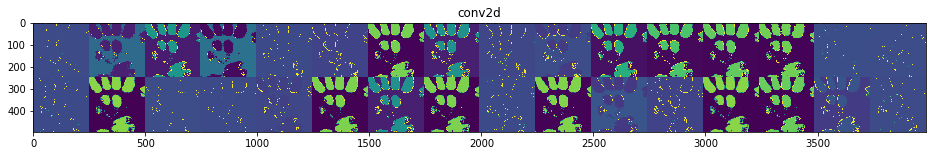

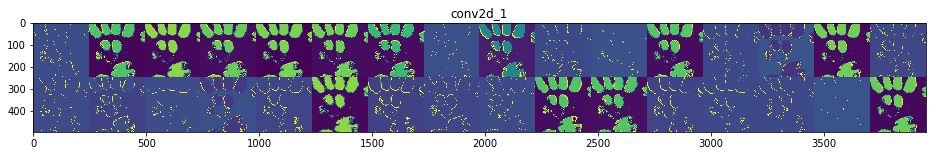

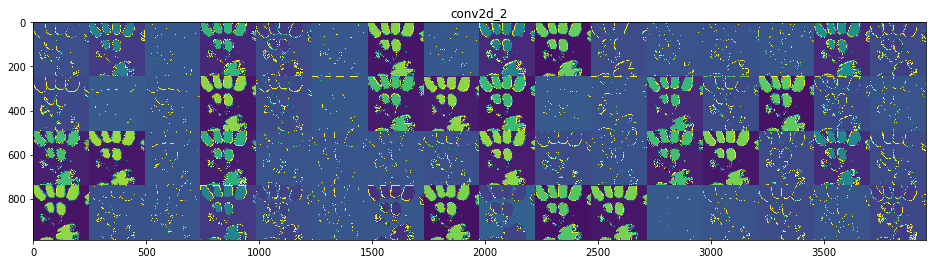

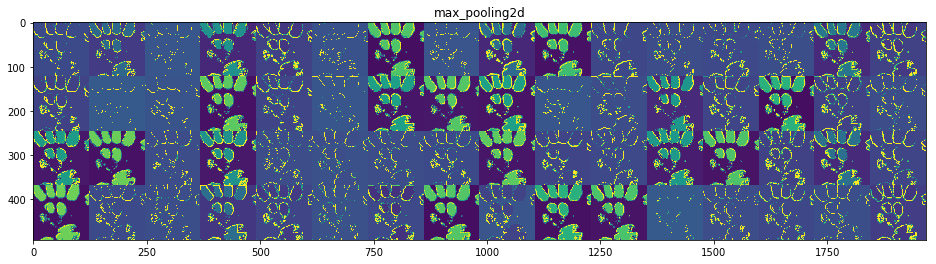

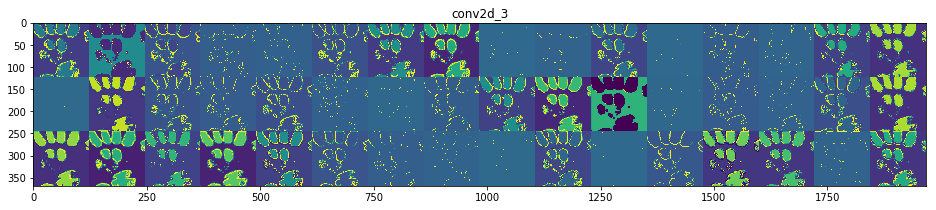

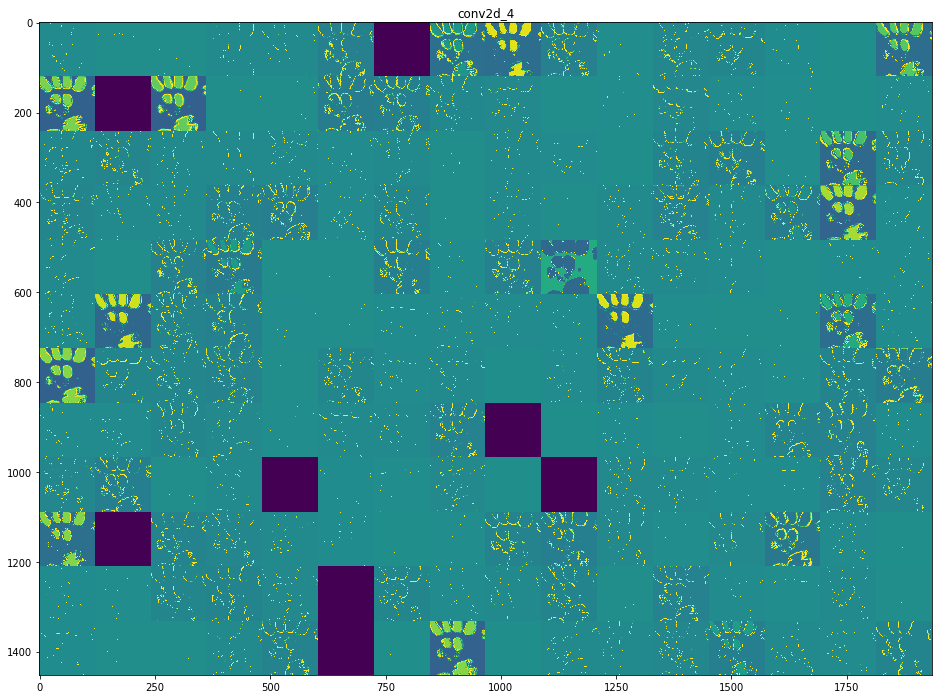

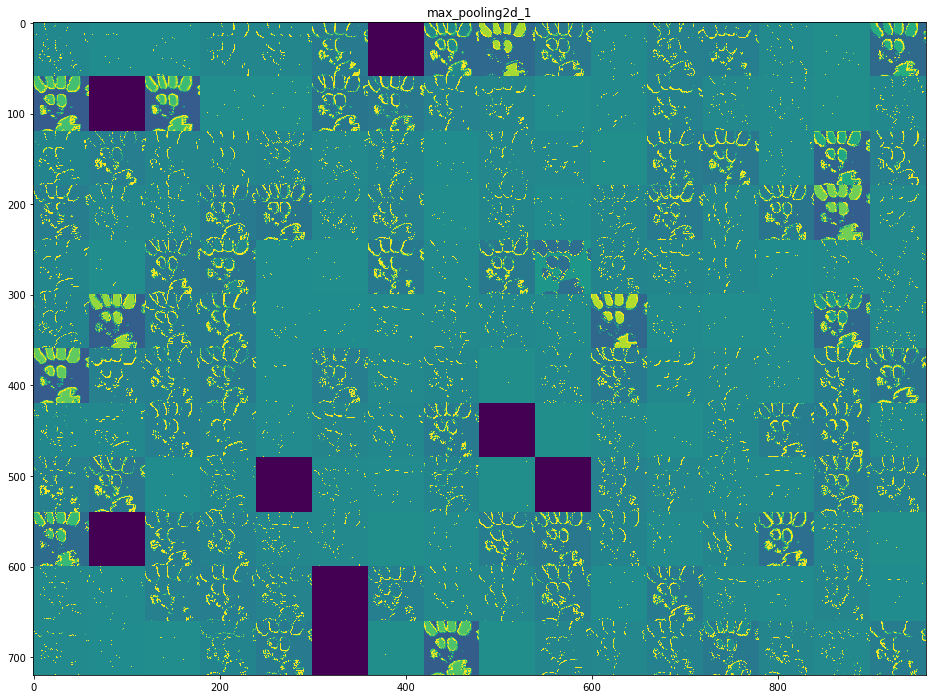

In [37]:
layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name)
images_per_row =16

for layer_name, layer_activation in zip(layer_names[1:], activations[1:]):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row*size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row+1) *size] =channel_image
    scale = 1./size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap= 'viridis')

# 모델 껍데기로 중간층 활성화

In [38]:
model_ = load_model(model_path+"tjnet.h5")

In [58]:
layer_outputs = [layer.output for layer in model_.layers[:9]]
activation_model = models.Model(inputs = model_.input, outputs=layer_outputs[:9])
activations = activation_model.predict(img_)

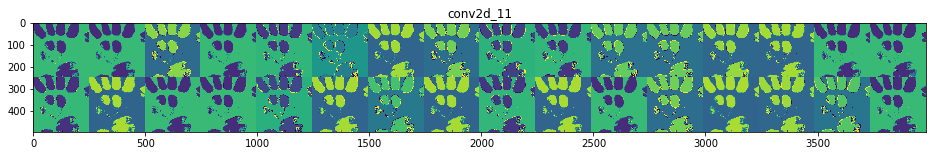

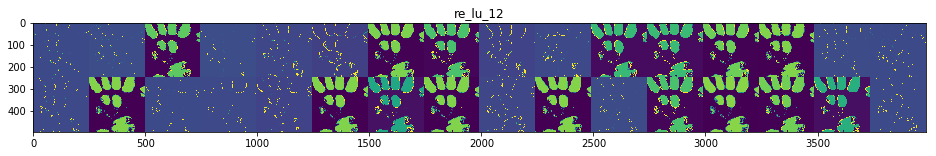

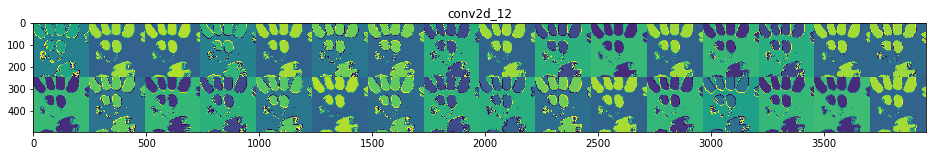

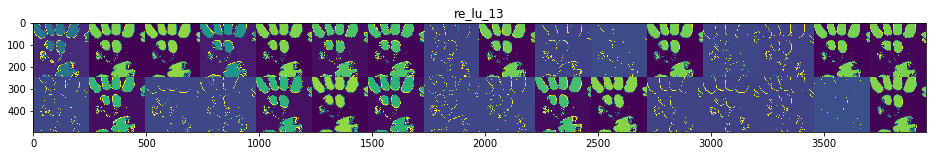

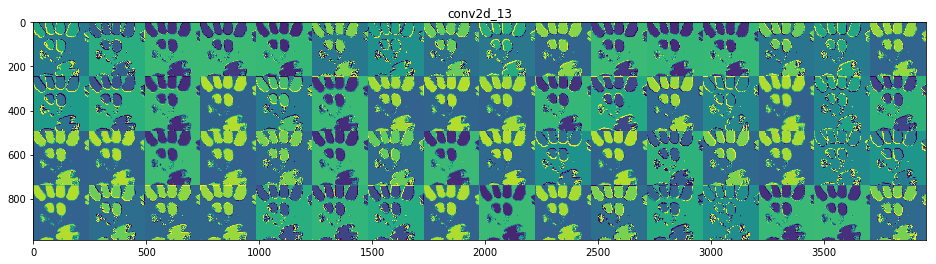

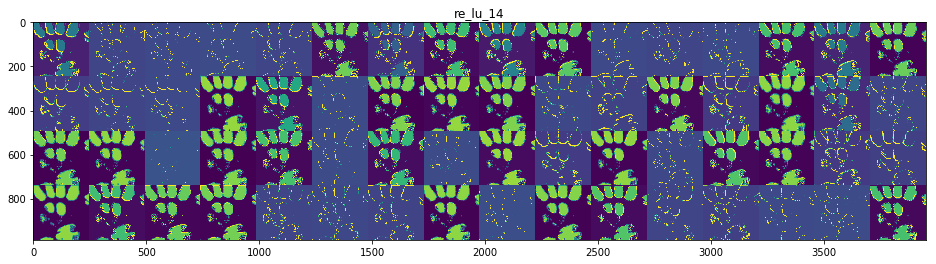

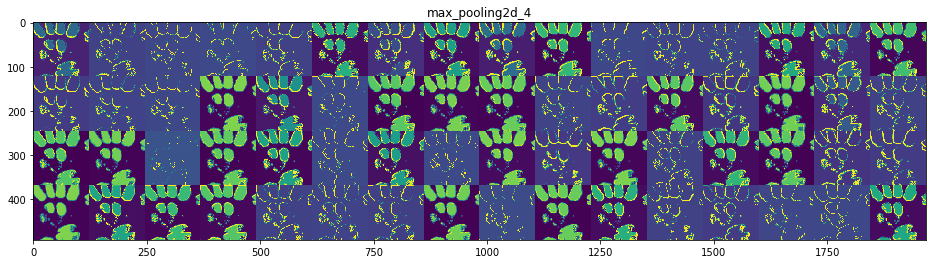

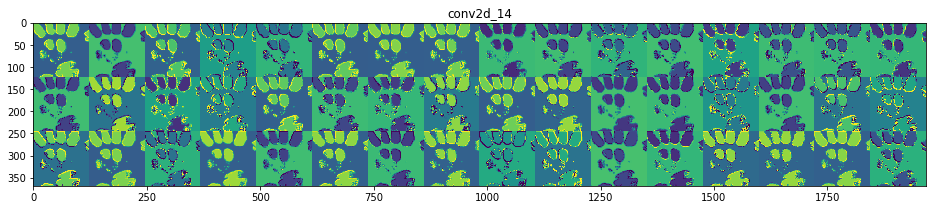

In [59]:
layer_names = []
for layer in model_.layers[:]:
    layer_names.append(layer.name)
images_per_row =16

for layer_name, layer_activation in zip(layer_names[1:], activations[1:]):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row*size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row+1) *size] =channel_image
    scale = 1./size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap= 'viridis')

# 클래스 활성화의 히트맵 시각화

In [41]:
import tensorflow.keras.backend as K

In [42]:
img_[1].shape

(1, 251, 251, 3)

#### 맨 마지막 층의 gradient를 tape에 저장한 후, output과 비교해서 그 차이를 텐서 객체 heatmap으로 만들어낸다

In [47]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_8')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(img_)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

#### heatmap을 150*150 사이즈로 바꾸고 형식도 이미지 형식으로 변환하는 과정

In [48]:
heatmap = np.max(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((8, 8))
heatmap = (heatmap-heatmap.mean())/heatmap.std()
heatmap = -heatmap/abs(heatmap.min())
heatmap = (heatmap-heatmap.min())/2
heatmap = cv2.resize(heatmap,(150,150))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

#### 원본 이미지를 가져와서 거기에 30%만큼 heatmap을 원본에 씌운다

In [50]:
org_path = "../../02_ImagePreprocessing/04_roi/"

In [51]:
org = cv2.imread(org_path+"001_04.jpg")
org = cv2.resize(org,(150,150))

In [52]:
final = heatmap*0.3 + org/2

In [53]:
def show(img):
    plt.figure(figsize=(6, 4))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = "gray")
    plt.show()

#### 결과값

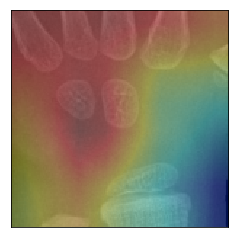

In [55]:
show(np.uint8(final))